In [2]:

import os
import sys
os.chdir("../../../../../../../../")
os.chdir("home/user/mnt/degelin/thesis")
!pip install matplotlib==3.7.0

In [3]:
import os
import pandas as pd
import sentence_transformers
import transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
os.chdir("../../../../../../..")
os.chdir("home/user/mnt/degelin/thesis")

In [4]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Available devices:")
print(torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"  Device {i}: {torch.cuda.get_device_name(i)}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.4.0+cu121
CUDA available: True
CUDA version: 12.1
Available devices:
1
  Device 0: NVIDIA RTX A6000
Using device: cuda


In [5]:
set_data_names = ['good_code/RS_withNames.csv', 'good_code/RS_withoutNames.csv']
model_names = []
rs_data_file = pd.read_csv('good_code/RS_withNames.csv')
full_data = pd.read_csv('good_code/updated_projects_labelled_inflation_adjusted2_modified.csv')

In [6]:
print("Columns of the rs_data_file DataFrame:")
print(rs_data_file.columns)

Columns of the rs_data_file DataFrame:
Index(['APPLICATION_ID', 'GRANT_ID', 'label', 'PI_GENDER', 'PI_RACE',
       'PROJECT_DESCRIPTION', 'GRANT_DESCRIPTION'],
      dtype='object')


In [7]:
# Calculate median value of 'formatted_cash' and 'formatted_year'
median_cash = full_data['GRANT_VALUE'].median()
mean_cash = full_data['GRANT_VALUE'].mean()



# Print the median values
print("Median value:", median_cash)
print("Median value:", mean_cash)

Median value of formatted_cash: 720000.0
Median value of formatted_year: 1114998.6753836353


In [8]:
model_save_path = "good_code/fine_tuned_models/original_withNames/fine_tuning-albert-albert-base-v2-2024-08-01_02-43-08"
model = SentenceTransformer(model_save_path)

In [31]:
def get_top_5_closest(proj_emb, grant_embs, grant_ids):
    cos_similarities = cosine_similarity(proj_emb.reshape(1, -1), grant_embs)[0]
    top_indices = cos_similarities.argsort()[-5:][::-1]
    top_grant_ids = [grant_ids[idx] for idx in top_indices]
    #print(top_grant_ids)
    return top_grant_ids

In [10]:
import torch
from torch.amp import autocast
import os
import numpy as np

def encode_and_save(data, column_name, output_file, batch_size=64, checkpoint_every=1000):
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Check if there's a checkpoint
    if os.path.exists(output_file):
        checkpoint = torch.load(output_file)
        start_idx = checkpoint['last_processed_idx'] + 1
        embeddings = checkpoint['embeddings']
    else:
        start_idx = 0
        embeddings = []

    total_items = len(data)
    
    with autocast("cuda"):
        for idx in range(start_idx, total_items, batch_size):
            batch = data[column_name].iloc[idx:idx+batch_size].tolist()
            batch_embeddings = model.encode(batch, show_progress_bar=False, device="cuda")
            embeddings.extend(batch_embeddings)
            
            # Save checkpoint
            if (idx + batch_size) % checkpoint_every == 0 or idx + batch_size >= total_items:
                checkpoint = {
                    'last_processed_idx': idx + len(batch) - 1,
                    'embeddings': embeddings
                }
                torch.save(checkpoint, output_file)
                print(f"Checkpoint saved. Processed {idx + len(batch)}/{total_items} items.")

    return np.array(embeddings)

# Encode and save project embeddings
proj_embeddings = encode_and_save(rs_data_file, 'PROJECT_DESCRIPTION', 'checkpoints/proj_embeddings.pt')

# Encode and save grant embeddings
grant_embeddings = encode_and_save(full_data, 'GRANT_DESCRIPTION', 'checkpoints/grant_embeddings.pt')

print("Encoding completed and saved to disk.")

Checkpoint saved. Processed 3706/3706 items.
Checkpoint saved. Processed 8000/80845 items.
Checkpoint saved. Processed 16000/80845 items.
Checkpoint saved. Processed 24000/80845 items.
Checkpoint saved. Processed 32000/80845 items.
Checkpoint saved. Processed 40000/80845 items.
Checkpoint saved. Processed 48000/80845 items.
Checkpoint saved. Processed 56000/80845 items.
Checkpoint saved. Processed 64000/80845 items.
Checkpoint saved. Processed 72000/80845 items.
Checkpoint saved. Processed 80000/80845 items.
Checkpoint saved. Processed 80845/80845 items.
Encoding completed and saved to disk.


In [14]:
def load_embeddings(checkpoint_file):
    if os.path.exists(checkpoint_file):
        checkpoint = torch.load(checkpoint_file, weights_only=False)
        embeddings = np.array(checkpoint['embeddings'])
        return embeddings
    else:
        raise FileNotFoundError(f"Checkpoint file {checkpoint_file} does not exist.")
    proj_embeddings = load_embeddings('checkpoints/proj_embeddings.pt')
    grant_embeddings = load_embeddings('checkpoints/grant_embeddings.pt')

    print("Embeddings loaded successfully.")

Embeddings loaded successfully.


In [32]:
def get_grant_values(application_ids):
    # Create a dictionary for faster lookup
    grant_value_dict = dict(zip(full_data['APPLICATION_ID'], full_data['GRANT_VALUE']))
    
    # List comprehension to get grant values
    grant_values = [grant_value_dict.get(app_id) for app_id in application_ids]
    
    return grant_values
def get_FOA_values(application_ids):
    # Create a dictionary for faster lookup
    grant_value_dict = dict(zip(full_data['APPLICATION_ID'], full_data['FOA_NUMBER']))
    
    # List comprehension to get grant values
    foa_values = [grant_value_dict.get(app_id) for app_id in application_ids]
    
    return foa_values


In [58]:
def determine_output_file_path(model_path, rs_file_path):
    # Define the output paths
    if 'without' in rs_file_path.lower():
        output_path = 'good_code/output_csvs/without/'
    else:
        output_path = 'good_code/output_csvs/with/'
    
    # Extract tuned_data and tuned_model from model_path
    parts = model_path.split('fine_tuned_models/')[1].split('/')
    tuned_data = parts[0]
    tuned_model = '_'.join(parts[1:])  # Join remaining parts with '_'
    
    # Construct the final model_path
    final_model_path = os.path.join(output_path, tuned_data + tuned_model)
    
    return final_model_path


good_code/output_csvs/without/perfect_withoutNamesfine_tuning-bionlp-bluebert_pubmed_mimic_uncased_L-12_H-768_A-12-2024-08-01_08-13-45


In [47]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

rs_data_file['APPLICATION_IDs'] = np.nan
rs_data_file['REC_GRANT_VALUES'] = np.nan
rs_data_file['REC_FOA_NUMBERS'] = np.nan
# Get the total number of projects
num_projects = len(rs_data_file)
# Iterate over each PROJ_DESCRIPTION with a progress bar
for idx in tqdm(range(num_projects), desc="Processing Projects", unit="project"):
    proj_emb = proj_embeddings[idx]
    
    # Get top 5 closest GRANT_DESCRIPTIONs
    top_grant_ids = get_top_5_closest(proj_emb, grant_embeddings, full_data['APPLICATION_ID'])
    top_grant_values = get_grant_values(top_grant_ids)
    foas = get_FOA_values(top_grant_ids)
    foas_str = [str(id) for id in foas]
    # Ensure all IDs are strings
    top_grant_ids_str = [str(id) for id in top_grant_ids]
    
    # Ensure all grant values are strings
    top_grant_values_str = [str(value) for value in top_grant_values]
    
    # Convert lists to comma-separated strings for storage in DataFrame
    rs_data_file.loc[idx, 'APPLICATION_IDs'] = ','.join(top_grant_ids_str)
    rs_data_file.loc[idx, 'REC_GRANT_VALUES'] = ','.join(top_grant_values_str)
    rs_data_file.loc[idx, 'REC_FOA_NUMBERS'] = ','.join(foas_str)
print("Processing completed and columns updated.")

Processing Projects:   0%|                        | 0/3706 [00:00<?, ?project/s]/tmp/ipykernel_7586/3813166149.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7756325,8322625,8316181,8322627,8102984' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rs_data_file.loc[idx, 'APPLICATION_IDs'] = ','.join(top_grant_ids_str)
/tmp/ipykernel_7586/3813166149.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2044000.0,1918000.0,1918000.0,1918000.0,1960000.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  rs_data_file.loc[idx, 'REC_GRANT_VALUES'] = ','.join(top_grant_values_str)
/tmp/ipykernel_7586/3813166149.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'rfa-hl-09-007,rfa-hl-09-007,rfa-

Processing completed and columns updated.


In [ ]:
print(rs_data_file.head())

In [55]:
#file_path = os.path.join(folderName, "projs.csv")

# Save the DataFrame
rs_data_file.to_csv('test_accuracy.csv', index=False)

In [ ]:
rs_data_file = pd.read_csv('good_code/test_accuracy.csv')


In [54]:
def measure_top1_accuracy(data, full_data):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0
    
    for idx, row in data.iterrows():
        true_application_id = str(row['APPLICATION_ID']).replace(' ', '')
        recommended_ids = row['APPLICATION_IDs'].replace(' ', '').split(',')
        recommended_foa_numbers = row['REC_FOA_NUMBERS'].replace(' ', '').split(',')
        
        if len(recommended_ids) > 0:
            top_recommended_id = recommended_ids[0]
            top_recommended_foa = recommended_foa_numbers[0] if len(recommended_foa_numbers) > 0 else None
            
            # Find the corresponding record in full_data
            full_data_record = full_data[full_data['APPLICATION_ID'] == int(true_application_id)]
            
            if not full_data_record.empty:
                true_foa_number = str(full_data_record.iloc[0]['FOA_NUMBER']).replace(' ', '')
                
                if top_recommended_foa == true_foa_number:
                    true_positive += 1
                else:
                    false_negative += 1
                    false_positive += 1
            else:
                false_negative += 1
        else:
            if pd.isna(true_application_id):
                true_negative += 1
            else:
                false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    accuracy = (true_positive + true_negative) / len(data) if len(data) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Example usage
measure_top1_accuracy(rs_data_file, full_data)


Precision: 0.2304
Recall: 0.2304
Accuracy: 0.2304


In [56]:
import pandas as pd

def measure_top1_accuracy(data):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0

    for idx, row in data.iterrows():
        true_application_id = str(row['APPLICATION_ID']).replace(' ', '')
        recommended_ids = str(row['APPLICATION_IDs']).replace(' ', '').split(',')
        recommended_foa_numbers = str(row['REC_FOA_NUMBERS']).replace(' ', '').split(',')

        if len(recommended_ids) > 0:
            top_recommended_id = recommended_ids[0]
            top_recommended_foa = recommended_foa_numbers[0] if len(recommended_foa_numbers) > 0 else None
            
            # Get the true FOA number from the same record
            true_foa_number = str(row['TRUE_GRANT']).replace(' ', '') if not pd.isna(row['TRUE_GRANT']) else None

            if true_foa_number and top_recommended_foa:
                # Check if the institution is the same
                if true_foa_number.split('-')[1] == top_recommended_foa.split('-')[1]:
                    true_positive += 1
                else:
                    false_positive += 1
                    false_negative += 1
            else:
                false_negative += 1
        else:
            if pd.isna(true_application_id):
                true_negative += 1
            else:
                false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    accuracy = (true_positive + true_negative) / len(data) if len(data) > 0 else 0

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Example usage
rs_data_file = pd.read_csv('test_accuracy.csv')
measure_top1_accuracy(rs_data_file)


Precision: 0.8206
Recall: 0.8206
Accuracy: 0.8206


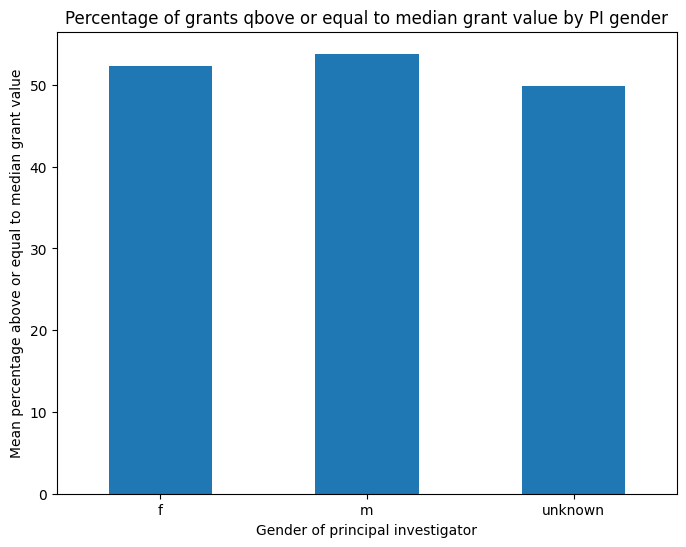

In [347]:
import matplotlib.pyplot as plt

# Group the data by PI_GENDER and calculate the mean ABOVE_MEDIAN for each group
gender_above_median_mean = projs.groupby('PI_GENDER')['ABOVE_MEDIAN'].mean()

# Plot the bar chart
plt.figure(figsize=(8, 6))
gender_above_median_mean.plot(kind='bar')
plt.title('Percentage of grants qbove or equal to median grant value by PI gender')
plt.xlabel('Gender of principal investigator')
plt.ylabel('Mean percentage above or equal to median grant value')
plt.xticks(rotation=0)
file_path = os.path.join(folderName, "gender_groups_bar.png")
plt.savefig(file_path)
plt.show()


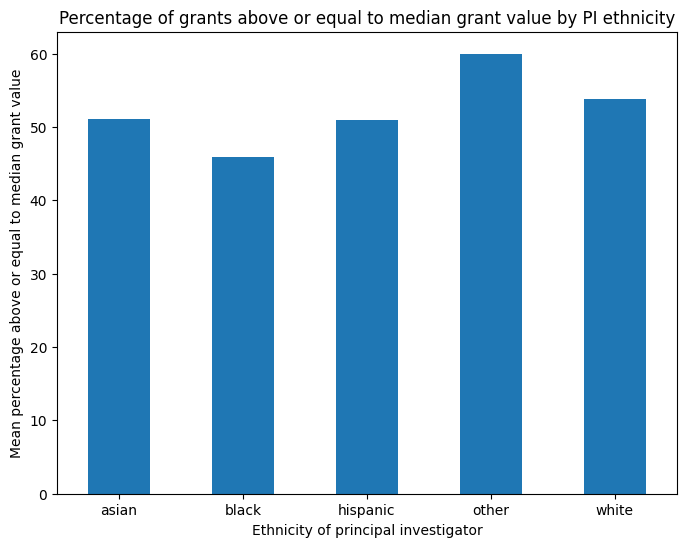

In [348]:
import matplotlib.pyplot as plt

# Group the data by PI_GENDER and calculate the mean ABOVE_MEDIAN for each group
gender_above_median_mean = projs.groupby('PI_ETHNICITY')['ABOVE_MEDIAN'].mean()

# Plot the bar chart
plt.figure(figsize=(8, 6))
gender_above_median_mean.plot(kind='bar')
plt.title('Percentage of grants above or equal to median grant value by PI ethnicity')
plt.xlabel('Ethnicity of principal investigator')
plt.ylabel('Mean percentage above or equal to median grant value')
plt.xticks(rotation=0)
file_path = os.path.join(folderName, "ethnicity_groups_bar.png")
plt.savefig(file_path)
plt.show()


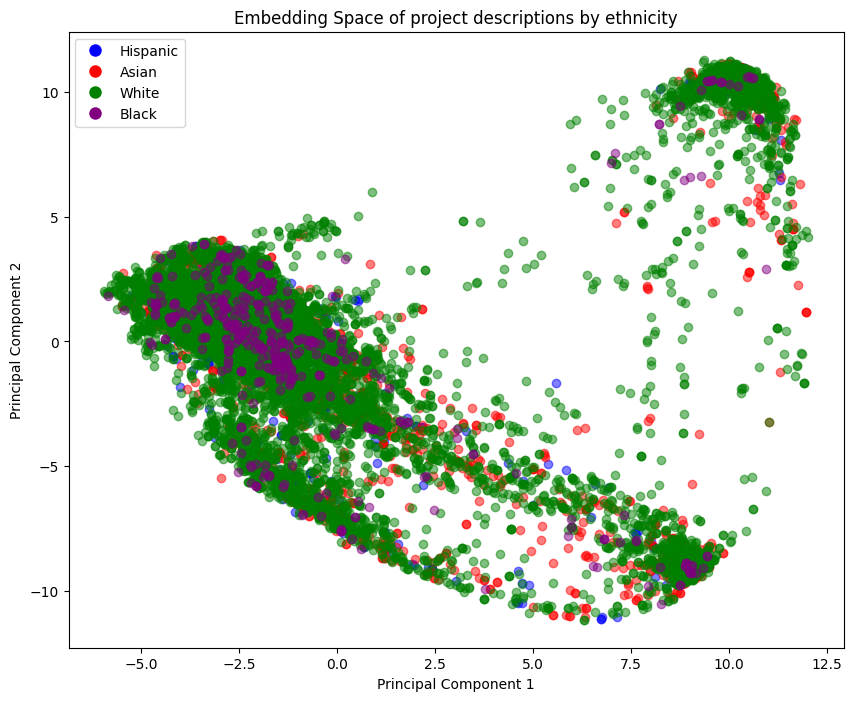

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
proj_embeddings_pca = pca.fit_transform(proj_embeddings)

# Color mappings for PI_ETHNICITY
race_color_map = {'hispanic': 'blue', 'asian': 'red', 'white': 'green', 'black': 'purple'}

# Extract colors and labels based on PI_ETHNICITY
legend_labels = {'hispanic': 'Hispanic', 'asian': 'Asian', 'white': 'White', 'black': 'Black'}
legend_handles = []
for race, label in legend_labels.items():
    color = race_color_map[race] if race in race_color_map else 'blue'
    rgba_color = plt.cm.colors.to_rgba(color)  # Convert color name to RGBA tuple
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=rgba_color, markersize=10, label=label))

# Plot the embedding space
plt.figure(figsize=(10, 8))
for race, color in race_color_map.items():
    indices = np.where(projs['PI_ETHNICITY'] == race)[0]
    plt.scatter(proj_embeddings_pca[indices, 0], 
                proj_embeddings_pca[indices, 1], 
                label=None, c=color, alpha=0.5)

plt.title('Embedding Space of project descriptions by ethnicity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=legend_handles)
file_path = os.path.join(folderName, "emb_pc_ethnicity_2d.png")
plt.savefig(file_path)
plt.show()


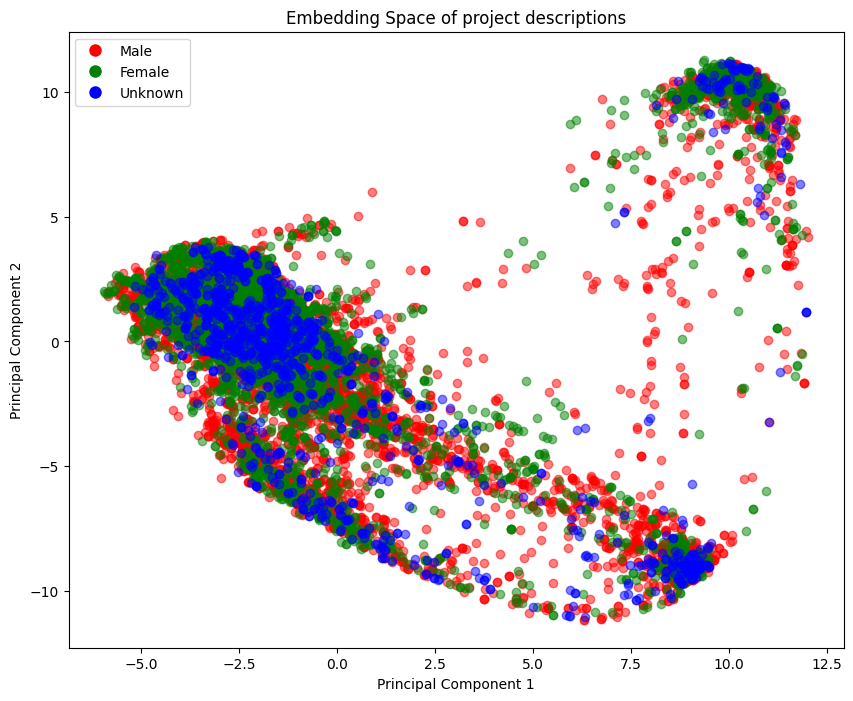

In [350]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
proj_embeddings_pca = pca.fit_transform(proj_embeddings)

# Color mappings for PI_GENDER
gender_color_map = {'m': 'red', 'f': 'green', 'unknown': 'blue'}

# Extract colors and labels based on PI_GENDER
legend_labels = {'m': 'Male', 'f': 'Female', 'unknown': 'Unknown'}
legend_handles = []
for gender, label in legend_labels.items():
    color = gender_color_map[gender] if gender in gender_color_map else 'blue'
    rgba_color = plt.cm.colors.to_rgba(color)  # Convert color name to RGBA tuple
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=rgba_color, markersize=10, label=label))

# Plot the embedding space
plt.figure(figsize=(10, 8))
for gender, color in gender_color_map.items():
    indices = np.where(projs['PI_GENDER'] == gender)[0]
    plt.scatter(proj_embeddings_pca[indices, 0], 
                proj_embeddings_pca[indices, 1], 
                label=None, color=color, alpha=0.5)

plt.title('Embedding Space of project descriptions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=legend_handles)
file_path = os.path.join(folderName, "emb_pc_gender_2d.png")
plt.savefig(file_path)
plt.show()


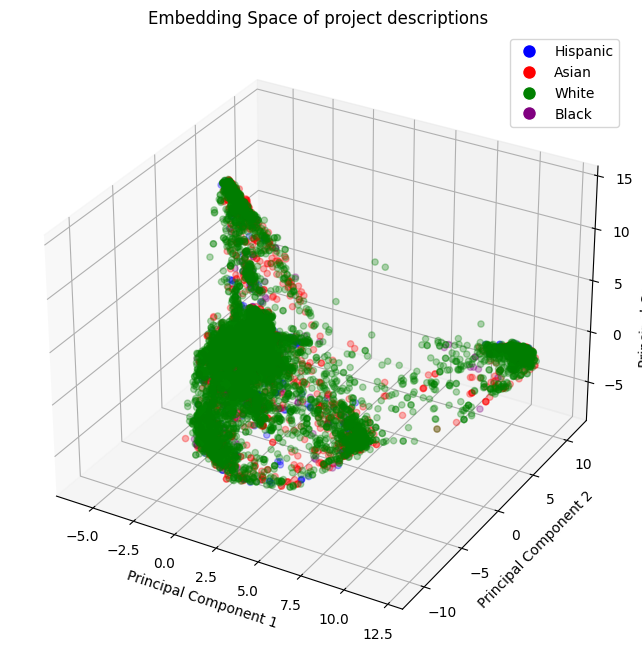

In [351]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction to 3 dimensions
pca = PCA(n_components=3)
proj_embeddings_pca = pca.fit_transform(proj_embeddings)

# Color mappings for PI_GENDER
race_color_map = {'hispanic': 'blue', 'asian': 'red', 'white': 'green', 'black': 'purple'}
colors = [race_color_map[race.lower()] if race.lower() in race_color_map else 'blue' for race in projs['PI_ETHNICITY']]
# Extract colors and labels based on PI_ETHNICITY
legend_labels = {'hispanic': 'Hispanic', 'asian': 'Asian', 'white': 'White', 'black': 'Black'}
legend_handles = []
for race, label in legend_labels.items():
    color = race_color_map[race] if race in race_color_map else 'blue'
    rgba_color = plt.cm.colors.to_rgba(color)  # Convert color name to RGBA tuple
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=rgba_color, markersize=10, label=label))

# Plot the embedding space in three dimensions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for color in set(colors):
    indices = [i for i, c in enumerate(colors) if c == color]
    ax.scatter(proj_embeddings_pca[indices, 0], 
               proj_embeddings_pca[indices, 1], 
               proj_embeddings_pca[indices, 2], 
               label=color, c=color, alpha=0.3)  # Adjust alpha here

ax.set_title('Embedding Space of project descriptions')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend(handles=legend_handles)
file_path = os.path.join(folderName, "emb_pc_ethnicity_3d.png")
plt.savefig(file_path)
plt.show()


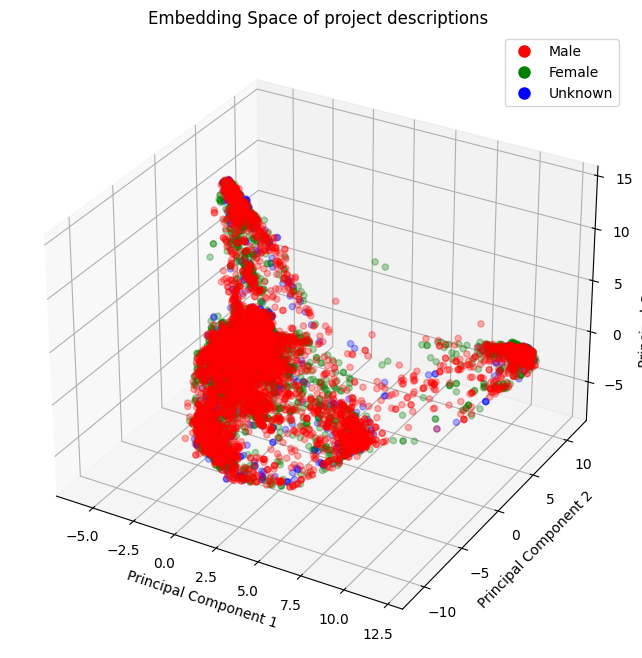

In [352]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction to 3 dimensions
pca = PCA(n_components=3)
proj_embeddings_pca = pca.fit_transform(proj_embeddings)

# Color mappings for PI_GENDER
gender_color_map = {'m': 'red', 'f': 'green', 'unknown': 'blue'}
colors = [gender_color_map[gender.lower()] if gender.lower() in gender_color_map else 'blue' for gender in projs['PI_GENDER']]
# Extract colors and labels based on PI_GENDER
legend_labels = {'m': 'Male', 'f': 'Female', 'unknown': 'Unknown'}
legend_handles = []
for gender, label in legend_labels.items():
    color = gender_color_map[gender] if gender in gender_color_map else 'blue'
    rgba_color = plt.cm.colors.to_rgba(color)  # Convert color name to RGBA tuple
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=rgba_color, markersize=10, label=label))

# Plot the embedding space in three dimensions
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for color in set(colors):
    indices = [i for i, c in enumerate(colors) if c == color]
    ax.scatter(proj_embeddings_pca[indices, 0], 
               proj_embeddings_pca[indices, 1], 
               proj_embeddings_pca[indices, 2], 
               label=color, c=color, alpha=0.3)  # Adjust alpha here

ax.set_title('Embedding Space of project descriptions')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend(handles=legend_handles)
file_path = os.path.join(folderName, "emb_pc_gender_3d.png")
plt.savefig(file_path)
plt.show()


In [ ]:
%%capture
!pip install seaborn

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Filter projs DataFrame by male and female projects
male_projs = projs[projs['PI_GENDER'] == 'm']
female_projs = projs[projs['PI_GENDER'] == 'f']
unknown_projs = projs[projs['PI_GENDER'] == 'unknown']

# Concatenate male and female project embeddings
male_embeddings = proj_embeddings[male_projs.index]
female_embeddings = proj_embeddings[female_projs.index]
unknown_embeddings = proj_embeddings[unknown_projs.index]
all_embeddings = np.concatenate([male_embeddings, female_embeddings, unknown_embeddings])

# Concatenate male and female project labels
male_labels = np.full((len(male_projs),), 'Male')
female_labels = np.full((len(female_projs),), 'Female')
unknown_labels = np.full((len(unknown_projs),), 'Unknown')
all_labels = np.concatenate([male_labels, female_labels, unknown_labels])

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
proj_embeddings_tsne = tsne.fit_transform(all_embeddings)

# Plot t-SNE visualization colored by gender
plt.figure(figsize=(10, 8))
sns.scatterplot(x=proj_embeddings_tsne[:, 0], y=proj_embeddings_tsne[:, 1], hue=all_labels, palette={'Male': 'red', 'Female': 'green', 'Unknown': 'blue'}, alpha=1)
plt.title('T-sne visualizations of representations of projects by PI gender')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Gender', loc='upper right')
file_path = os.path.join(folderName, "emb_tsne_gender_2d.png")
plt.savefig(file_path)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Filter projs DataFrame by male and female projects
hispanic_projs = projs[projs['PI_ETHNICITY'] == 'hispanic']
asian_projs = projs[projs['PI_ETHNICITY'] == 'asian']
white_projs = projs[projs['PI_ETHNICITY'] == 'white']
black_projs = projs[projs['PI_ETHNICITY'] == 'black']

# Concatenate male and female project embeddings
hispanic_embeddings = proj_embeddings[hispanic_projs.index]
asian_embeddings = proj_embeddings[asian_projs.index]
white_embeddings = proj_embeddings[white_projs.index]
black_embeddings = proj_embeddings[black_projs.index]

all_embeddings = np.concatenate([hispanic_embeddings, asian_embeddings, white_embeddings, black_embeddings])

# Concatenate male and female project labels
hispanic_labels = np.full((len(hispanic_projs),), 'Hispanic')
asian_labels = np.full((len(asian_projs),), 'Asian')
white_labels = np.full((len(white_projs),), 'White')
black_labels = np.full((len(black_projs),), 'Black')

all_labels = np.concatenate([hispanic_labels, asian_labels, white_labels, black_labels])

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
proj_embeddings_tsne = tsne.fit_transform(all_embeddings)

# Plot t-SNE visualization colored by gender
plt.figure(figsize=(10, 8))
sns.scatterplot(x=proj_embeddings_tsne[:, 0], y=proj_embeddings_tsne[:, 1], hue=all_labels, palette={'Hispanic': 'blue', 'Asian': 'red', 'White': 'Green', 'Black': 'purple'}, alpha=1)
plt.title('T-sne visualizations of representations of projects by PI ethnicity')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Ethnicity', loc='upper right')
file_path = os.path.join(folderName, "emb_tsne_ethnicity_2d.png")
plt.savefig(file_path)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)

# Plot t-SNE visualization for Hispanic projects
male_embeddings_tsne = tsne.fit_transform(male_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(male_embeddings_tsne[:, 0], male_embeddings_tsne[:, 1], label='Male', c='red', alpha=0.7)

# Plot t-SNE visualization for Asian projects
female_embeddings_tsne = tsne.fit_transform(female_embeddings)
plt.scatter(female_embeddings_tsne[:, 0], female_embeddings_tsne[:, 1], label='Female', c='green', alpha=0.7)

# Plot t-SNE visualization for White projects
unknown_embeddings_tsne = tsne.fit_transform(unknown_embeddings)
plt.scatter(unknown_embeddings_tsne[:, 0], unknown_embeddings_tsne[:, 1], label='Unknown', c='blue', alpha=0.7)

plt.title('T-sne visualizations of representations of projects by PI gender')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
file_path = os.path.join(folderName, "emb_tsne_ethnicity2_2d.png")
plt.savefig(file_path)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)

# Plot t-SNE visualization for Hispanic projects
spanic_embeddings_tsne = tsne.fit_transform(spanic_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(spanic_embeddings_tsne[:, 0], spanic_embeddings_tsne[:, 1], label='Hispanic', c='blue', alpha=0.7)

# Plot t-SNE visualization for Asian projects
asian_embeddings_tsne = tsne.fit_transform(asian_embeddings)
plt.scatter(asian_embeddings_tsne[:, 0], asian_embeddings_tsne[:, 1], label='Asian', c='red', alpha=0.7)

# Plot t-SNE visualization for White projects
white_embeddings_tsne = tsne.fit_transform(white_embeddings)
plt.scatter(white_embeddings_tsne[:, 0], white_embeddings_tsne[:, 1], label='White', c='green', alpha=0.7)

# Plot t-SNE visualization for Black projects
black_embeddings_tsne = tsne.fit_transform(black_embeddings)
plt.scatter(black_embeddings_tsne[:, 0], black_embeddings_tsne[:, 1], label='Black', c='purple', alpha=0.7)

plt.title('T-sne visualizations of representations of projects by PI ethnicity')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
file_path = os.path.join(folderName, "emb_tsne_gender2_2d.png")
plt.savefig(file_path)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE to reduce dimensionality to 3D
tsne = TSNE(n_components=3, random_state=42)

# Plot t-SNE visualization for Hispanic projects
spanic_embeddings_tsne = tsne.fit_transform(spanic_embeddings)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
hispanic_scatter = ax.scatter(spanic_embeddings_tsne[:, 0], spanic_embeddings_tsne[:, 1], spanic_embeddings_tsne[:, 2], label='Hispanic', c='blue', alpha=0.05)

# Plot t-SNE visualization for Asian projects
asian_embeddings_tsne = tsne.fit_transform(asian_embeddings)
ax.scatter(asian_embeddings_tsne[:, 0], asian_embeddings_tsne[:, 1], asian_embeddings_tsne[:, 2], label='Asian', c='red', alpha=0.05)

# Plot t-SNE visualization for White projects
white_embeddings_tsne = tsne.fit_transform(white_embeddings)
ax.scatter(white_embeddings_tsne[:, 0], white_embeddings_tsne[:, 1], white_embeddings_tsne[:, 2], label='White', c='green', alpha=0.01)  # Decrease alpha value

# Plot t-SNE visualization for Black projects
black_embeddings_tsne = tsne.fit_transform(black_embeddings)
ax.scatter(black_embeddings_tsne[:, 0], black_embeddings_tsne[:, 1], black_embeddings_tsne[:, 2], label='Black', c='purple', alpha=0.1)

ax.set_title('T-sne visualizations of representations of projects by PI ethnicity')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')

# Create custom legend handles with solid colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for color, label in [('blue', 'Hispanic'), ('red', 'Asian'), ('green', 'White'), ('purple', 'Black')]]

# Display legend with custom handles
ax.legend(handles=legend_handles)

# Adjust axis limits for better visualization
ax.set_xlim(-50, 50)  # Example limits, adjust as needed
ax.set_ylim(-50, 50)
ax.set_zlim(-50, 50)

file_path = os.path.join(folderName, "ethnicity_groups_tsne.png")
plt.savefig(file_path)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply t-SNE to reduce dimensionality to 3D
tsne = TSNE(n_components=3, random_state=42)

male_embeddings_tsne = tsne.fit_transform(male_embeddings)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
male_scatter = ax.scatter(male_embeddings_tsne[:, 0], male_embeddings_tsne[:, 1], male_embeddings_tsne[:, 2], label='Male', c='red', alpha=0.05)

# Plot t-SNE visualization for Asian projects
female_embeddings_tsne = tsne.fit_transform(female_embeddings)
ax.scatter(female_embeddings_tsne[:, 0], female_embeddings_tsne[:, 1], female_embeddings_tsne[:, 2], label='Female', c='green', alpha=0.05)

# Plot t-SNE visualization for White projects
unknown_embeddings_tsne = tsne.fit_transform(unknown_embeddings)
ax.scatter(unknown_embeddings_tsne[:, 0], unknown_embeddings_tsne[:, 1], unknown_embeddings_tsne[:, 2], label='Unknown', c='blue', alpha=0.05)  # Decrease alpha value

('T-sne visualizations of representations of projects by PI gender')
ax.set_title('T-sne visualizations of representations of projects by PI gender')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')

# Create custom legend handles with solid colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for color, label in [('red', 'Male'), ('green', 'Female'), ('blue', 'Unknown')]]

# Display legend with custom handles
ax.legend(handles=legend_handles)

# Adjust axis limits for better visualization
ax.set_xlim(-50, 50)  # Example limits, adjust as needed
ax.set_ylim(-50, 50)
ax.set_zlim(-50, 50)

file_path = os.path.join(folderName, "gender_groups_tsne.png")
plt.savefig(file_path)
plt.show()
